In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Flatten, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sna
import numpy as np
import os
import pandas as pd
import pywt

In [44]:
epoch_num = 5
sequence_length = 8  # Number of time steps to consider

# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data_main = pd.read_csv(data_path, usecols=ucols)
data_main.reset_index(drop=True, inplace=True)
data_main.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


In [45]:
df = data_main.iloc[:1000]
# Convert DataFrame to NumPy array
# data = df.values

In [46]:
# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

def apply_dwt(data):
    coeffs = [pywt.dwt(sample, 'haar') for sample in data]
    cA, cD = zip(*coeffs)
    return np.array(cA)  # Using only approximation coefficients

# Apply DWT
transformed_data = apply_dwt(df_scaled)
transformed_data = transformed_data.reshape((transformed_data.shape[0], transformed_data.shape[1], 1))

# Define LSTM Autoencoder
def create_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input_layer)
    x = LSTM(32, return_sequences=False)(x)
    encoded = Dense(16, activation='relu')(x)
    
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder


In [47]:
# Train Autoencoder
autoencoder, encoder = create_autoencoder(transformed_data.shape[1:])
autoencoder.fit(transformed_data, transformed_data, epochs=5, batch_size=32, verbose=1)

# Extract Features
features = encoder.predict(transformed_data)

# Clustering with TimeSeriesKMeans
num_clusters = 3  # Buy (2), Sell (1), Hold (0)
tskmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", random_state=42)
clusters = tskmeans.fit_predict(features)
clusters_one_hot = tf.keras.utils.to_categorical(clusters, num_clusters)

# Split Data for Training
X_train, X_test, y_train, y_test = train_test_split(features, clusters_one_hot, test_size=0.2, random_state=42)

# Define Classifier
input_shape = features.shape[1:]  # Extract feature dimension
classifier_input = Input(shape=input_shape)
classifier_output = Dense(num_clusters, activation="softmax")(classifier_input)

classifier = Model(classifier_input, classifier_output)
classifier.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train Classifier
classifier.fit(X_train, y_train, epochs=5, batch_size=5, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")






Epoch 1/5
32/32 [==============================] - 3s 3ms/step - loss: 0.1056
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 5/5
32/32 [==============================] - 1s 2ms/step
Epoch 1/5
160/160 [==============================] - 1s 2ms/step - loss: 1.1532 - accuracy: 0.4175 - val_loss: 0.8232 - val_accuracy: 0.7850
Epoch 2/5
160/160 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.8737 - val_loss: 0.6550 - val_accuracy: 0.8300
Epoch 3/5
160/160 [==============================] - 0s 1ms/step - loss: 0.5562 - accuracy: 0.8775 - val_loss: 0.5748 - val_accuracy: 0.8300
Epoch 4/5
160/160 [==============================] - 0s 1ms/step - loss: 0.4815 - accuracy: 0.8775 - val_loss: 0.5184 - val_accuracy: 0.8300
Epoch 5/5
7/7 [==============================] - 0s 911us/ste

NameError: name 'confusion_matrix' is not defined

In [49]:
# Confusion Matrix & Classification Report
y_pred = classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

7/7 [==============================] - 0s 0s/step
Confusion Matrix:
[[ 40   0   0]
 [  0 126   0]
 [  4  30   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        40
           1       0.81      1.00      0.89       126
           2       0.00      0.00      0.00        34

    accuracy                           0.83       200
   macro avg       0.57      0.67      0.62       200
weighted avg       0.69      0.83      0.75       200



C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [60]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=['Hold', 'Sell', 'Buy'], yticklabels=['Hold', 'Sell', 'Buy'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'sns' is not defined

<Figure size 600x500 with 0 Axes>

23/23 [==============================] - 0s 978us/step


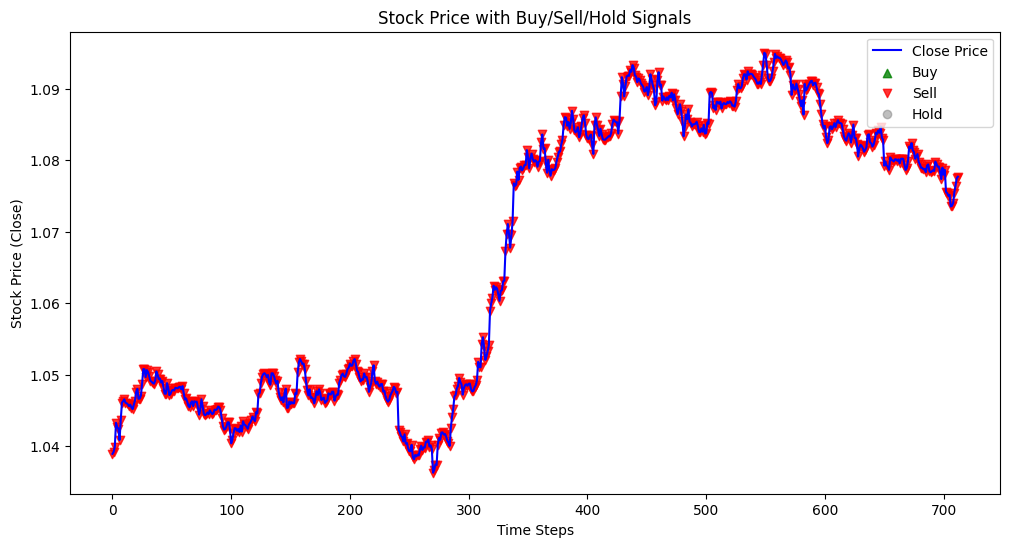

['Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',

In [59]:
# Predict on New Data
def predict_new_data(new_data):
    new_data_scaled = scaler.transform(new_data)
    transformed_new_data = apply_dwt(new_data_scaled)
    transformed_new_data = transformed_new_data.reshape((transformed_new_data.shape[0], transformed_new_data.shape[1], 1))
    features_new = encoder.predict(transformed_new_data)
    predictions = classifier.predict(features_new)
    predicted_classes = np.argmax(predictions, axis=1)
    labels = {0: "Hold", 1: "Sell", 2: "Buy"}
    return predicted_classes, [labels[p] for p in predicted_classes]

# Example Usage
# new_data = pd.read_csv("new_stock_data.csv", usecols=['Open', 'High', 'Low', 'Close']).values
predicted_classes, predictions = predict_new_data(ohlc_data)

# Plot OHLC with Predictions
plt.figure(figsize=(12, 6))
plt.plot(new_data[:, 3], label='Close Price', color='blue')

buy_signals = np.where(np.array(predicted_classes) == 2)[0]
sell_signals = np.where(np.array(predicted_classes) == 1)[0]
hold_signals = np.where(np.array(predicted_classes) == 0)[0]

plt.scatter(buy_signals, new_data[buy_signals, 3], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, new_data[sell_signals, 3], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, new_data[hold_signals, 3], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price (Close)")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Signals")
plt.show()

print(predictions)


In [57]:
# documentation: https://www.mql5.com/en/docs/integration/python_metatrader5

import MetaTrader5 as mt  # pip install MetaTrader5
import pandas as pd  # pip install pandas
from datetime import datetime, timedelta
import os

# start the platform with initialize()
mt.initialize()

# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 165905041
password = 'iIeElL0176_'
server = 'XMGlobal-MT5 2'

mt.login(login, password, server)



# Define symbol and timeframe
symbol = "EURUSD"
timeframe = mt.TIMEFRAME_H1

# Get data for the last 48 hours
end_time = datetime.now()
start_time = end_time - timedelta(hours=1000)

# Retrieve OHLC data
ohlc_data = pd.DataFrame(mt.copy_rates_range(symbol, timeframe, start_time, end_time))

# Convert time column to datetime format
ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')


ohlc_data.rename(columns={'open':'Open', 'high':'High', 
                        'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
columns_to_drop = ['time', 'spread', 'real_volume', 'Volume']
ohlc_data.drop(columns=[col for col in columns_to_drop if col in ohlc_data.columns], inplace=True)



In [58]:
ohlc_data

,Open,High,Low,Close
0,1.03890,1.04061,1.03745,1.03916
1,1.03916,1.04005,1.03808,1.03988
2,1.03988,1.04374,1.03988,1.04324
3,1.04324,1.04445,1.04235,1.04266
4,1.04263,1.04381,1.04241,1.04244
...,...,...,...,...
708,1.07401,1.07567,1.07399,1.07547
709,1.07548,1.07680,1.07542,1.07643
710,1.07643,1.07792,1.07641,1.07749
711,1.07749,1.07789,1.07720,1.07771
